## Application of deep learning approach to classify SARS-CoV-2 variants


### Coding Notebook
### Install and load the following libraries and packages

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from keras import utils as np_utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from keras import utils as np_utils
from numpy import array
import seaborn as sns
from sklearn.metrics import confusion_matrix

2022-04-17 11:58:22.467064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 11:58:22.467121: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Loading datasets and preprocessing

dataset_1 - a small dataset of 86 sequences for trial runs <br>
dataset_2 - sequence dataset with over 26000 used for training and validating the model

In [65]:
dataset_1 = pd.read_table("ml_sarscov2/data/variants.aln4.fas.txt", usecols=[1,2] ) #initial dataset with 86 sequneces
dataset_2 = 'ml_sarscov2/data/sequences.aln.fas' # huge dataset with 26k sequences

In [66]:
#Converting sequence data into data frame
#Ensure the fasta sequences are in one-liner and not blocks
#The sequence file had been pre-processed to include varinat names in the sequnce headers. Check file in fasta format.

inputfile = dataset_2

lines = []
header = []
with open (inputfile, 'r') as fasta_file:
    
    for line in fasta_file:
        if line.startswith(">"):
            #extract fasta headers
            lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))
            
        next
            #extract sequence lines
        if not line.startswith(">"):
            header.append(line.replace("\n",''))

#Create dictionary of header and sequences and create a datafram
data = {lines[i]:header[i] for i in range(len(header))}
data = pd.DataFrame(list(data.items()),columns = ['Seq_ID','sequence']) 


data["sequence"] = data["sequence"].str.upper() #ensure the sequence is un uppercase. Important for encoding

data["Variant_Id"] = data["Seq_ID"].apply(lambda i: i.split('/')[0]) #extracting variant names from sequnce file

data = data.drop("Seq_ID", axis=1)

dataset_1["sequence"] = dataset_1['sequence'].str.upper() 

dataset_2 = data

dataset = [dataset_1, dataset_2]

Plot number of sequences for each variant

<AxesSubplot:title={'center':'Variant data'}>

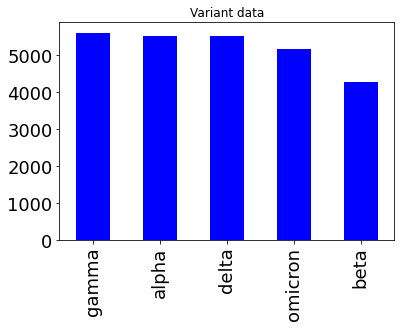

In [77]:
dataset_2["Variant_Id"].value_counts().plot(kind="bar", 
                                            title = "Variant data", 
                                            fontsize=18,
                                           color = "blue")

### Assign variant name to numerical form

gamma - 0 \
delta - 1 \
beta - 2 \
alpha - 3 \
omicron - 4

In [4]:
def variant_annotation(dataset):
    variant = {"gamma" : 0, "delta" : 1, "beta" : 2, "alpha" : 3, "omicron":4}

    for seq_data in dataset:
        seq_data["Variant_Id"] = seq_data["Variant_Id"].map(variant)
    return dataset

variant_annotation(dataset)

dataset_1.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0


In [5]:
def encode_seq(seq_data):
    """
    Function to convert nucleotides to binary form and hot-encoded

    Arguments :
    seq_data = sequence dataframe with "sequence" and "Variant_ID" columns

    char : total number of unique characters in the whole dataset. This is used to 
    bin : array list of zeros corresponding to the number of characters

    """

    ntds = []
    for i in seq_data['sequence']:
        for seq in i:
            ntd = seq.strip()
            ntds.append(ntd.upper())
        
    char = list(set(ntds))
    
    bin = [0] * len(char)
    bin0  = [0] * len(char)
    bin1  = [0] * len(char)
    bin2  = [0] * len(char)
    bin3  = [0] * len(char)
    
    #Create a dictionary of arrays to the seqeunce characters
    Encode = {}

    for i in char:
        if i == 'A':
            bin0[0] = 1
            Encode[i] = bin0
        elif i == 'C':
            bin1[1] = 1
            Encode[i] = bin1
        elif i == 'G':
            bin2[2] = 1
            Encode[i] = bin2
        elif i == 'T':
            bin3[3] = 1
            Encode[i] = bin3
        else:
            Encode[i] = bin
    
      #convert the sequence characters to encoded form and append to the list

    encoded_list = []

    for seq in seq_data["sequence"]:
        encoded_list.append([Encode[x] for x in seq])

    return encoded_list

### **Performing K-Merization**
Sequences will be converted to k-mers (kmer of 4) form

In [45]:
#Get a copy of the dataset

dataset_1_k = dataset_1.copy()
dataset_2_k = dataset_2.copy()

kmer_data = [dataset_1_k, dataset_2_k]

#### Convert sequences to k-mers form

In [16]:
def getKmers(sequence, size=4):
    """"
    function to convert sequence strings into k-mer words, default size = 4 (hexamer words)

    Arguments:
    sequence = sequnce set 
    size = size of kmers 
    """
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

for seq_data in kmer_data:
    seq_data['sequence'] = seq_data.apply(lambda x: getKmers(x['sequence']), axis=1)

#### Encode the sequence data

In [79]:
#call function to encode the sequences and convert to array form
encoded = encode_seq(dataset_2) 
X_mine_data_kmer = np.array(encoded)

#set variable for 
y_mine_kmer_2 = dataset_2['Variant_Id']

#y_mine_kmer_2.shape

(26037,)

### **Model Fitting**
Split the dataset into training and validation (80:20) ration.

In [30]:
#Split dataset into training and validation
X_train, X_test, y_train, y_test = train_test_split(X_mine_data_kmer_2, y_mine_kmer_2, random_state = 42, stratify = y_mine_kmer_2)

#have the data in tensor-readable form. I also don't know what that means.
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

Set the model 

In [31]:
#Model parameter setting

gru_model = Sequential()

#Layer 1 - feature extraction
#Performs dimension reduction

gru_model.add(Conv1D(filters = 54, kernel_size = (6), activation = 'relu', input_shape = X_mine_data_kmer_2.shape[1:])) #ensure you change the shape
gru_model.add(MaxPooling1D(pool_size= (5)))
gru_model.add(Dropout(0.5))

#layer2
gru_model.add(Conv1D(filters = 27, kernel_size = (3), activation = 'relu', padding = 'same'))
gru_model.add(MaxPooling1D(pool_size= (3)))


#layer3
gru_model.add(Conv1D(filters = 14, kernel_size = (2), activation = 'relu', padding = 'same'))
gru_model.add(MaxPooling1D(pool_size= (3)))
gru_model.add(Dropout(0.2))

#layer4
gru_model.add(Conv1D(filters = 7, kernel_size = (2), activation = 'relu', padding = 'same'))
gru_model.add(MaxPooling1D(pool_size= (3)))
gru_model.add(Bidirectional(GRU(512, activation = 'relu')))
gru_model.add(Dropout(0.01))

#Hidden dense layer
gru_model.add(Dense(256, activation = 'relu'))
gru_model.add(Dense(128, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(32, activation = 'relu'))
gru_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
gru_model.add(Dense(5, activation = 'softmax'))


#Flatten
gru_model.add(Flatten()) #right place for flattening

gru_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

gru_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 3869, 54)          4266      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 773, 54)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 773, 54)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 773, 27)           4401      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 257, 27)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 257, 14)          

In [32]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )
history = gru_model.fit(X_train, y_train, batch_size = 1000, validation_data=(X_test, y_test), 
                        epochs=30)

Epoch 1/30
20/20 [==============================] - 29s 1s/step - loss: 0.6988 - accuracy: 0.2123 - val_loss: 0.6811 - val_accuracy: 0.2149
Epoch 2/30
20/20 [==============================] - 23s 1s/step - loss: 0.6668 - accuracy: 0.2132 - val_loss: 0.6515 - val_accuracy: 0.2117
Epoch 3/30
20/20 [==============================] - 23s 1s/step - loss: 0.6390 - accuracy: 0.2211 - val_loss: 0.6219 - val_accuracy: 0.4174
Epoch 4/30
20/20 [==============================] - 23s 1s/step - loss: 0.5804 - accuracy: 0.3029 - val_loss: 0.4576 - val_accuracy: 0.3656
Epoch 5/30
20/20 [==============================] - 23s 1s/step - loss: 0.4396 - accuracy: 0.5119 - val_loss: 0.3435 - val_accuracy: 0.5857
Epoch 6/30
20/20 [==============================] - 23s 1s/step - loss: 0.3492 - accuracy: 0.6091 - val_loss: 0.2863 - val_accuracy: 0.7788
Epoch 7/30
20/20 [==============================] - 23s 1s/step - loss: 0.2909 - accuracy: 0.7130 - val_loss: 0.2280 - val_accuracy: 0.7966
Epoch 8/30
20/20 [==

## Explore Results 

### 1. Plot accuracy and loss values of the training dataset

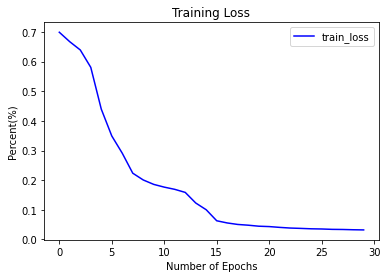

In [61]:
# Plot the loss and accuracy curves for training

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='b', label="train_loss")
plt.title("Training Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Percent(%)")
plt.legend()
plt.savefig("training_loss.png")

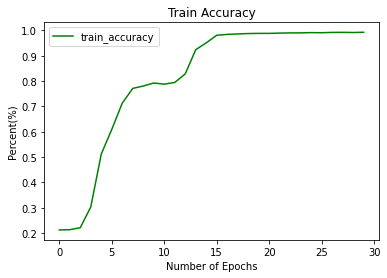

In [59]:
# Plot the test accuracy

plt.plot(history.history['accuracy'], color='g', label="train_accuracy")
plt.title("Train Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Percent(%)")
plt.legend()
#plt.savefig("loss_accuracy.png")

### 2. Plot accuracy and loss values of the validation dataset

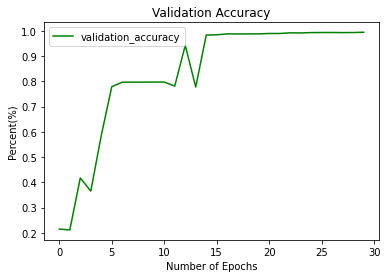

In [60]:
# Plot the accuracy for validation

plt.plot(history.history['val_accuracy'], color='g', label="validation_accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Percent(%)")
plt.legend()
#plt.savefig("loss_accuracy.png")

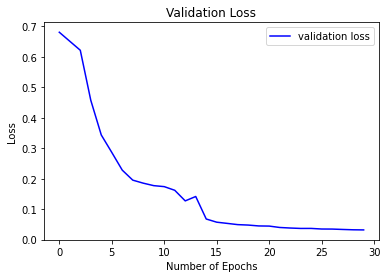

In [62]:
# Plot the loss and accuracy curves for validation 

import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("validation_loss.png")

### 3. Confusion matrix of the validation dataset

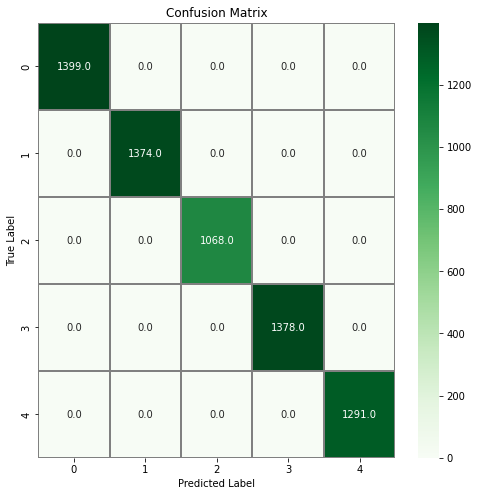

In [34]:
# Predict the values from the validation dataset
Y_pred = gru_model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_test,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion.png")